# TP Optimisation II:  A simple neural network 

### Nom(s): SOTORIVA LERMEN
### Prénom(s): Thiago
### Groupe: B2

## Useful packages

In [20]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

## Loading of the train and test data

In [21]:
#
# Load train data
#
Xtrain = np.load('train-images.npy')
Xtrain = np.array([x.ravel()/255 for x in Xtrain])
Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1],1)
Ytrain = np.load('train-labels.npy')
targets_train = []

#
# Convert digits to 10x1 vectors
#
for lab in Ytrain:
    v      = np.zeros((10,1))
    v[lab] = 1
    targets_train+=[np.array(v)]

#
# Load test data
#
Xtest        = np.load('t10k-images.npy')
Xtest        = np.array([x.ravel()/255 for x in Xtest])
Xtest        = Xtest.reshape(Xtest.shape[0],Xtest.shape[1],1)
Ytest        = np.load('t10k-labels.npy')
targets_test = []

#
# Convert digits to 10x1 vectors
#
for lab in Ytest:
    v = np.zeros((10,1))
    v[lab]=1
    targets_test+=[np.array(v)]
#
# Outputs
#
print('There are ',Xtrain.shape[0],'images in the train set')
print('There are ',Xtest.shape[0],'images in the test set')

There are  60000 images in the train set
There are  10000 images in the test set


## Definition of the activation function

 The activation function defines the output of a node given a set of inputs. We use the <a href="https://en.wikipedia.org/wiki/Softmax_function">softmax</a> function defined by
 
 $$\sigma_{\alpha} : \mathbb{R}^p\rightarrow [0,1]^p, \quad \mbox{ s.t.} \quad[\sigma_{\alpha}(x)]_i=\frac{e^{x_i+\alpha_i}}{\displaystyle{\sum_{j=1}^{p}e^{x_j+\alpha_j}}}\quad \forall i=1:p. $$  


In [22]:
#
# Nonlinear activation function
#
def softmax(x,alpha):
    """
    Softmax unit activation function 
    x    : Numpy array
    alpha: scalar
    """ 
    
    xs = x + alpha
    value = np.zeros((len(x),1))
    value = np.exp(xs) * (1 / np.sum(np.exp(xs)))
    
    return value

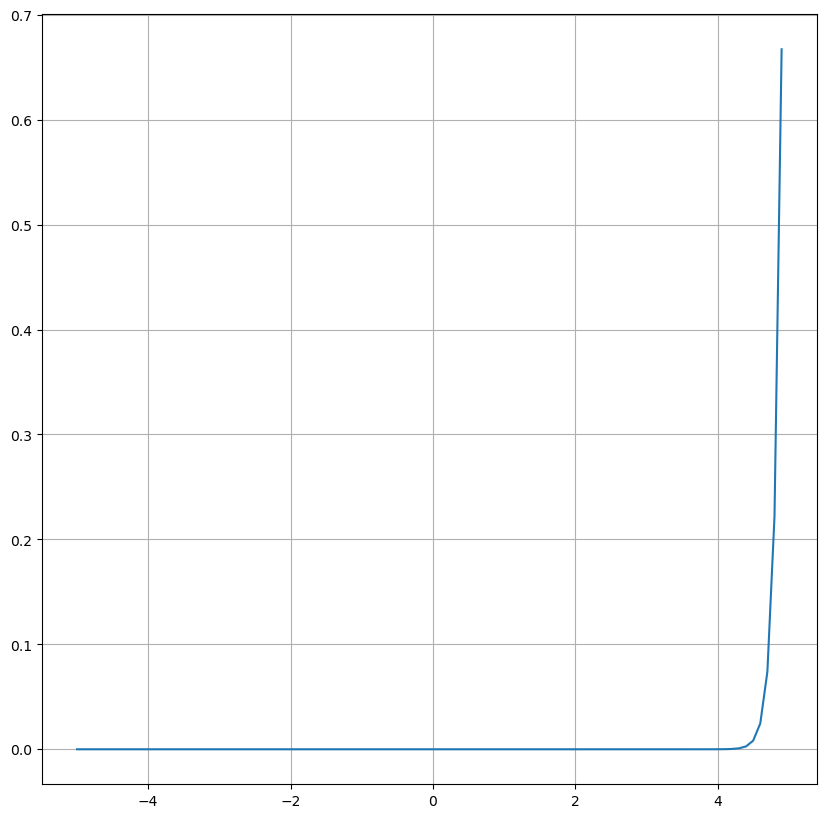

In [23]:
#
# Example of a plot of the activation function
#
t     = np.arange(-5,5,0.1)
alpha = np.arange(-50,50,1)
plt.figure(figsize=(10,10))
plt.plot(t,softmax(t,alpha))
plt.grid(True)
plt.show()

## Definition of a simple neural network

We use a one-layer fully-connected neural network with the <a href="https://en.wikipedia.org/wiki/Softmax_function">softmax</a> activation function.


In [24]:
def NN(x,W):
    """
    # One-layer fully connected neural network
    # x: image, i.e. 784x1 vector (28x28)
    # W: weight matrices of shape 10x784   
    """
    #
    # return pred (predicted probabilities) 
    #
    y = W@x
    pred = softmax(y, np.size(W[:,0]))
    return pred

## Definition of the loss function

The loss function is the <a href="https://en.wikipedia.org/wiki/Cross_entropy">cross-entropy</a> defined by 

$$J(W)=-\sum_{i=1}^N p_i \log(q_i(W)),$$ where $N$ is the number of classes, $(p_i)_{i=1:N}$ are the probabilities of  a data from the training set to belong to a class (0 or 1 because the labels are known), and $(q_i(W))_{i=1:N}$ are the predicted probabilities from the model

$$\forall i=1:N, \quad q_i(W)=[\sigma_{\alpha}(Wx)]_i.$$

In [25]:
#
# Loss function = Cross-entropy
#
def cross_entropy(pred,target,x):
    """
    pred:   predicted probabilities (q(W))
    target: probabilities (p)
    x:      image 
    """ 
    #
    # return ce (cross_entropy)
    #
    ce = -np.sum(target.T@np.log(pred))
    #
    # gradient of the cross-entropy
    s = pred
    u    =  np.ones((s.shape[0],1))
    g    = (-u.T.dot(target)*(s.dot(x.T))+target*x.T)
    grad = -g.reshape(x.shape[0]*target.shape[0],1)
    
    return ce,grad
#
# Main function 
#
def f(W,x,target):
    """
    W:      weights
    target: probabilities (p)
    x:      image
    """
    #
    # return ce, grad, pred (cross_entropy, gradient, predicted probabilities)
    #
    pred = NN(x, W)
    ce, grad = cross_entropy(pred, target, x)
    
    return ce,grad,pred

In [26]:
#
# Test information on the gradient with calls of f
#

# Define weight matrices
W      = np.random.rand(10,Xtrain.shape[1])
eps    = 1e-8
d      = np.random.rand(10,Xtrain.shape[1])
Wtilde = W+eps*d

# Retrieve the information on the gradients
res    = (f(Wtilde,Xtrain[0],targets_train[0])[0]-f(W,Xtrain[0],targets_train[0])[0])/eps
print(res)

g      = f(W,Xtrain[0],targets_train[0])[1]
print(g.T.dot(d.reshape(7840,1)))

1.7685991338112217
[[1.76859741]]


## Generating batches 

In [27]:
#
# Function to create batches of samples to be used later in the training phase
#
def create_batches(x,bs):
    """
    x : set to be considered (array)
    bs: batch size (scalar)
    """
    batches = []
    ind     = np.arange(x.shape[0])
    random.shuffle(ind)
    nbatch  = ind.shape[0]//bs
    rest    = ind.shape[0]%bs
    
    for n in range(nbatch):
        batches +=[ind[bs*n:bs*(n+1)]]
    
    # Put the remaining elements in a last batch
    if rest !=0:        
        batches += [ind[-rest:]]
        
    return batches

## Training of the neural network

In [32]:
history    = {}
eta        = 1e-5 # learning rate
momentum   = 0.   # momemtum factor
N_EPOCHS   = 10  
BatchSizes = [10000,1024,256] # try different batch sizes for the analysis

for bs in BatchSizes:
    #
    # Sensitivity to the batch size to be investigated in the analysis
    #
    print('batch size=',bs)
    
    history[bs]={'train loss':[],'train acc':[],'test loss':[0], 'test acc':[0]}
    
    # Initialization of the weights
    w = np.random.rand(10,Xtrain.shape[1])
    
    for n in range(N_EPOCHS):
        # Minimization of the loss function
        
        Batches=create_batches(Xtrain,bs)
        
        for batch in Batches:
            # Loop on the batches
            train_acc = 0
            ce_train = 0
            accumulated_grad = 0
            
            for img in batch:
                
                # For each image in the batch we apply the forward prop
                # 1. Generate the prediction
                # 2. Update the gradient and loss values for the batch
                # 3. Using argmax verify if the predictions corresponds to the true value
                x = Xtrain[img]
                y_target = targets_train[img]
                ce,grad,y_pred = f(w,x,y_target)
                accumulated_grad += grad
                ce_train += ce
                
                y_pred_idx = list(y_pred).index(np.max(y_pred))
                y_target_idx = list(y_target).index(1)
                if y_pred_idx == y_target_idx:
                    train_acc += 1
                
            history[bs]['train acc'] += [train_acc/batch.shape[0]]
            history[bs]['train loss'] += [ce_train/batch.shape[0]]
            
            # In the batch, apply the back prop updating the weights
            # of the network based on the accumulated gradient
            accumulated_grad = accumulated_grad.reshape(w.shape[0],w.shape[1])
            w = w - eta*accumulated_grad
 
        # Test accuracy at the end of each epoch  
        test_acc = 0
        ce_test = 0
        
        for i, img in enumerate(Xtest):
            
            # Apply the forward prop generating the prediction 
            # and compare with the target label
            y_target = targets_test[i]
            ce,_,y_pred = f(w,img,y_target)
            ce_test += ce
            
            y_pred_idx = list(y_pred).index(np.max(y_pred))
            y_target_idx = list(y_target).index(1)
            if y_pred_idx == y_target_idx:
                test_acc += 1
        
        # Update the test data
        history[bs]['test acc'] += [test_acc/Xtest.shape[0]]
        history[bs]['test loss'] += [ce_test/Xtest.shape[0]]
        
        print('Epoch number :', n+1,'test accuracy:',history[bs]['test acc'][n+1],'test loss',history[bs]['test loss'][n+1])
        

    print('\n')            

batch size= 10000
Epoch number : 1 test accuracy: 0.1797 test loss 2.9528038002556714
Epoch number : 2 test accuracy: 0.2815 test loss 2.4026423052615473
Epoch number : 3 test accuracy: 0.373 test loss 2.027015556094077
Epoch number : 4 test accuracy: 0.4438 test loss 1.7553624826224212
Epoch number : 5 test accuracy: 0.4969 test loss 1.5542826754996337
Epoch number : 6 test accuracy: 0.5446 test loss 1.4012182405850995
Epoch number : 7 test accuracy: 0.5789 test loss 1.2819685960221265
Epoch number : 8 test accuracy: 0.6115 test loss 1.1871486045579949
Epoch number : 9 test accuracy: 0.6339 test loss 1.109992233563308
Epoch number : 10 test accuracy: 0.6552 test loss 1.0460609287682514


batch size= 1024
Epoch number : 1 test accuracy: 0.1305 test loss 3.296895129054934
Epoch number : 2 test accuracy: 0.2133 test loss 2.6656163750393014
Epoch number : 3 test accuracy: 0.3021 test loss 2.2391893386461157
Epoch number : 4 test accuracy: 0.3867 test loss 1.930955188411481
Epoch number : 

## Plots of the evolution of the loss function

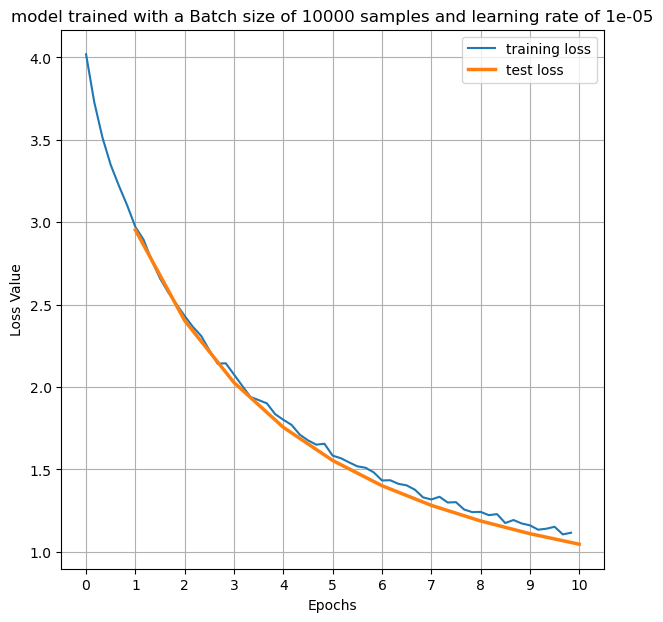

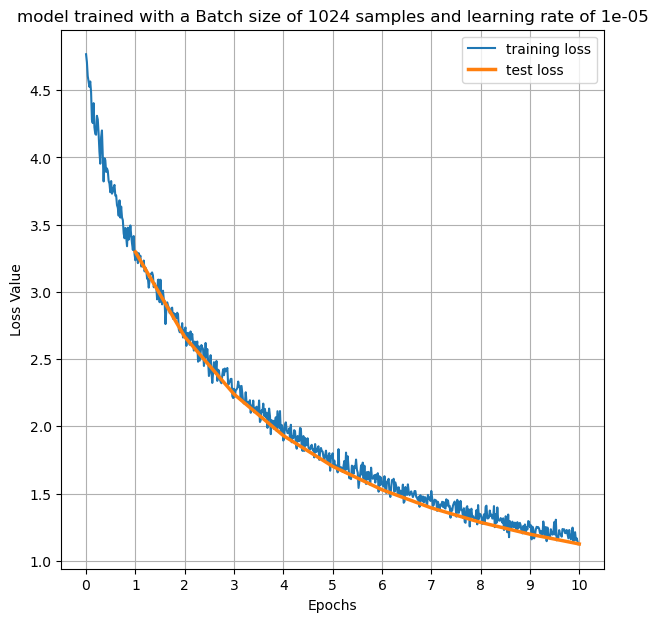

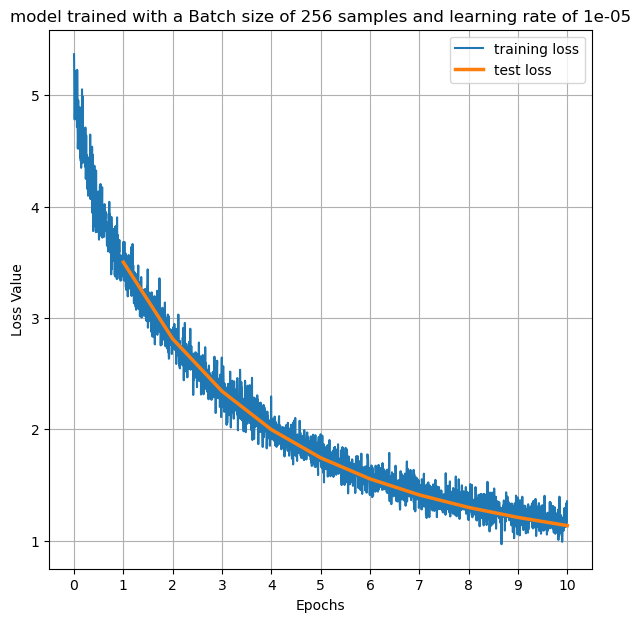

In [33]:
for bs in BatchSizes:
       
    n_batch = Xtrain.shape[0]//bs     
    if Xtrain.shape[0]%bs!=0:
        n_batch+=1
        
    E  = [n_batch*n for n in np.arange(N_EPOCHS+1)]
    Ep = [str(n) for n in np.arange(N_EPOCHS+1)]
    
    plt.figure(figsize=(7,7))
    plt.plot(history[bs]['train loss'],label = 'training loss')
    plt.plot(E[1:],history[bs]['test loss'][1:],linewidth=2.5,label = 'test loss')
    plt.xticks(E,Ep)
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    #plt.ylim([0,np.max(history[bs]['test loss'])+2])
    plt.grid(True)
    plt.legend()
    plt.title(f'model trained with a Batch size of {bs} samples and learning rate of {eta}')
    plt.show()

## Plots of the evolution of the accuracy

10000
6


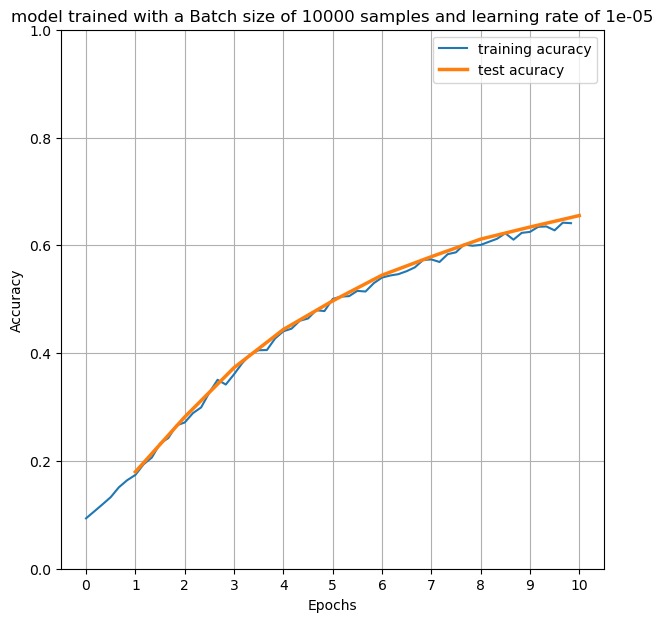

1024
59


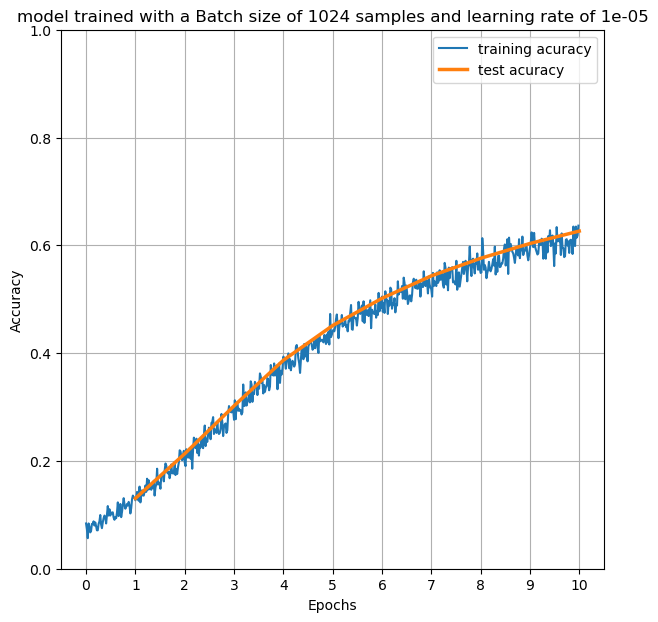

256
235


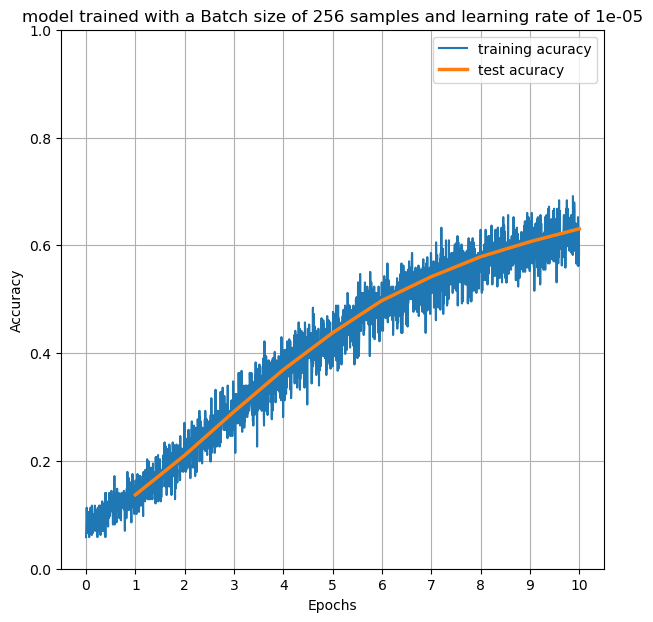

In [34]:
for bs in BatchSizes:
    print(bs)   
    n_batch = Xtrain.shape[0]//bs     
    if Xtrain.shape[0]%bs!=0:
        n_batch+=1
        
    print(n_batch)
    E=[n_batch*n for n in np.arange(N_EPOCHS+1)]
    Ep = [str(n) for n in np.arange(N_EPOCHS+1)]
    
    plt.figure(figsize=(7,7))
    plt.plot(history[bs]['train acc'] ,label  = 'training acuracy')
    plt.plot(E[1:],history[bs]['test acc'][1:],linewidth=2.5,label = 'test acuracy')
    plt.xticks(E,Ep)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.title(f'model trained with a Batch size of {bs} samples and learning rate of {eta}')
    plt.ylim([0,1])
    plt.legend()
    
    plt.show()

## Analysis of the results

Please provide your comments on the sensitivity of the results to the parameters involved in the learning process (batch size, learning rate, momentum).

### Your comments:

**Influence du batch size et learning rate** :
Les données fournies montrent l’effet de la taille des lots sur l’exactitude et la perte du modèle pendant la formation. Le taux d’apprentissage et les valeurs de momentum sont fixés à 1e-05 et 0.0, respectivement. Trois tailles de lot différentes sont testées : 10000, 1024 et 256.

Pour une taille de lot de 10000, la précision du test passe de 0,1797 à 0,6552 sur 10 époques. Au même moment, la perte d’essai passe de 2,9528038002556714 à 1,0460609287682514. Pour une taille de lot de 1024, la précision du test augmente de 0,1305 à 0,6264 sur 10 époques, tandis que la perte du test diminue de 3,296895129054934 à 1,1249048203076788. Pour une taille de lot de 256, la précision de test augmente de 0,1371 à 0,6307 sur 10 époques, tandis que la perte de test diminue de 3,5004673712671392 à 1,1339772322842085.

Les données suggèrent qu’une plus petite taille de lot entraîne généralement une plus grande précision et une perte plus faible. Le modèle formé avec une taille de lot de 256 montre les meilleurs résultats en termes de précision finale et les valeurs de perte. Cependant, il est important de noter que l’utilisation d’une taille de lot plus petite peut augmenter le temps de calcul requis pour la formation sur le modèle.

Les graphiques illustrant l’évolution de la précision et de la perte pendant la formation sur le modèle indiquent que l’utilisation de lots plus petits entraîne une convergence plus faible. En particulier, en traçant les valeurs d’entraînement et d’essai en fonction de l’époque, on peut observer que les valeurs d’entraînement oscillent autour des valeurs d’essai, l’ampleur de cette oscillation devenant plus prononcée à mesure que la taille du lot diminue. En d’autres termes, des lots plus petits peuvent entraîner une variabilité accrue du rendement du modèle pendant la formation.

Lors d’une inspection visuelle, les valeurs de formation montrent des fluctuations importantes autour de la valeur d’essai, mais il y a peu ou pas d’amélioration de la précision d’essai et des valeurs de perte.

Lorsqu’un taux d’apprentissage de 1e-05 est utilisé, une représentation graphique montre une amélioration de la précision et une diminution de la perte pour toutes les tailles de lot comme une courbe qui évolue progressivement avec l’époque.

Lorsqu’un taux d’apprentissage supérieur de 1e-03 est employé avec 10 époques et une taille de lot de 256, la précision de test est de 0,913, et la perte de test est de 0,304758475691756. Par rapport aux autres valeurs d’eta, la précision est très élevée, et la perte est significativement plus faible. Graphiquement, la courbe montre une croissance substantielle au début, se stabilisant autour d’une valeur après quelques époques pour les petites tailles de lots. Cependant, pour une grande taille de lot de 1024, les courbes de test sont moins stables, et les valeurs de précision et de perte n’évoluent pas continuellement vers une valeur presque constante comme les autres tailles de lot.